In [1]:
import numpy as np
import torch
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
from model import AttentionModel
from model_PCA_correlation import AttentionModel_PCA
from dcascore import *
from utils import read_fasta_alignment, remove_duplicate_sequences, add_PCA_coords

# back to original path (in PLM)
sys.path.pop(0)  # Removes the parent_dir from sys.path
from model import AttentionModel

from plm_gen_methods import generate_plm_n_save, generate_coords_n_save
from seq_utils import read_tensor_from_txt, set_seed, letters_to_nums, modify_seq 


## Model 1

In [2]:
"""
    Load Q, K, V matrices from jdoms (after training)
"""
set_seed()
H = 64
d= 10
N = 174
n_epochs = 500
nb_PCA_comp=2
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
cwd = parent_dir
Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_brute_force_35_bins/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_brute_force_35_bins/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_brute_force_35_bins/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N=Q_1.shape
q=V_1.shape[1]


In [3]:
model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)

torch.Size([64, 65, 65])
34
65


## MODEL 2

In [4]:
H = 64
d= 10
N = 174
n_epochs = 500
nb_PCA_comp=2
loss_type = 'without_J'
family = 'jdoms' #'jdoms_bacteria_train2'
cwd = parent_dir
Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_youss/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N=Q_1.shape
q=V_1.shape[1]

In [5]:
model=AttentionModel(H,d,N,q,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

i_indices = torch.arange(L, device=device).unsqueeze(1)
j_indices = torch.arange(L, device=device).unsqueeze(0)
mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
W = W * mask
    
# Compute Jtens
Jtens = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)
print(Jtens.shape)
print(Jtens.shape[-1])

torch.Size([64, 63, 63])
21
63
torch.Size([21, 21, 63, 63])
63


In [6]:
Q_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_2models_35_bins/Q_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
K_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_2models_35_bins/K_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
V_1 = read_tensor_from_txt( cwd +"/results/{H}_{d}_{family}_{losstype}_{n_epochs}_PCA_2models_35_bins/V_tensor.txt".format(H=H, d=d, family=family, losstype=loss_type, n_epochs=n_epochs))
H,d,N1=Q_1.shape
_,_,N2=K_1.shape
_,q1,q2=V_1.shape
model=AttentionModel_PCA(H,d,N1,N2,q1,q2,Q=Q_1,V=V_1,K=K_1)
torch.sum(model.Q-Q_1)
device = Q_1.device
L = Q_1.shape[-1]
W=attention_heads_from_model(model,Q_1,K_1,V_1)
print(W.shape)

# i_indices = torch.arange(L, device=device).unsqueeze(1)
# j_indices = torch.arange(L, device=device).unsqueeze(0)
# mask = (i_indices != j_indices).float().unsqueeze(0)  # shape (1, L, L)
# W = W * mask
    
# Compute Jtens
Jtens_PCA = torch.einsum('hri,hab->abri', W, V_1)  # Shape: (q, q, L, L)
q = Jtens.shape[0]
N = Jtens.shape[2]
print(q)
print(N)
print(Jtens_PCA.shape)

torch.Size([64, 63, 2])
21
63
torch.Size([21, 34, 63, 2])


## Generate PCA coords

Total sequences read: 14502
Sequences after filtering: 14502
(63, 14502)
Removing duplicate sequences...
Done: 14502 -> 14502 sequences after removing duplicates.
[26 21]
initial sequence number: [20 20  4  3  9  4  5 17  3 14 14 13  2 14  0 13  9  2  0 14 18  8  3  9
 13 14 13  0  6 12  2 14  4  0 15  3  5  0  0  0 13 18 15 17 14  7 11  3
  0 19 13 14  9  8  3 12  9 16 14  0  0 19 20 26 21]


  0%|          | 0/1 [00:00<?, ?it/s]

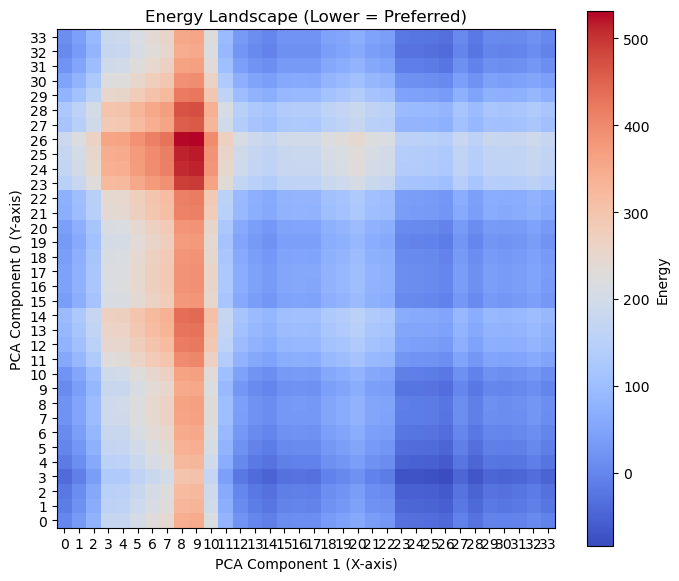

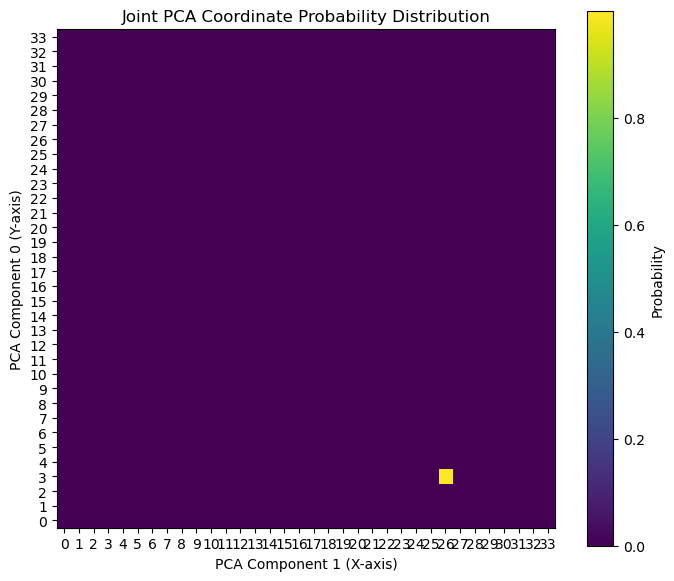

100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

PCA coordinates saved to generated_coords_2Model_PCA_PCA_coord3_26_
done generating coords with PLM from a fixed sequence sequence


In [7]:
import platform

if platform.system() == "Darwin":  # macOS
    base_path = '/Users/marzioformica/Desktop/EPFL/Master/StageLBS/PCA_gen_AI/CODE/DataAttentionDCA/jdoms'
else:  # assume Windows for Youss
    base_path = r"C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main\CODE\DataAttentionDCA\jdoms"

file_test_data = f"{base_path}/jdoms_bacteria_train2.fasta"
seq_data_test=read_fasta_alignment(file_test_data,0.8)

print(seq_data_test.shape)
seq_data_test_filtered,_=remove_duplicate_sequences(seq_data_test)
seq_data_test_filtered=seq_data_test_filtered.T
seq_data_test_filtered_with_PCA= add_PCA_coords(seq_data_test_filtered,35) #####DONT FORGET TO CHANGE NUMBER OF BINS IF NECESSARY


#init_sequence = 'DYYQVLGVPKDADAKSIKKAFRKLARKYHPDVNPGDKEAERKFKEANEANEVLSDPEKRKKYD'
init_sequence_num = seq_data_test_filtered_with_PCA[12919]
print(init_sequence_num[-2:])
print("initial sequence number:", init_sequence_num)
ratio = 0.
init_sequence_num = modify_seq(init_sequence_num, ratio,nb_PCA_comp=2)
N_iter=1

save_dir = "generated_coords_2Model_PCA"
save_name = f"gen_coords_Ns{N_iter}_r{ratio}"
#target_coords = np.array([20, 20])  # Example target coordinates for PCA components
generate_coords_n_save(save_dir=save_dir, save_name=save_name, J=Jtens, N_iter = N_iter, init_sequence=init_sequence_num,nb_PCA_comp=nb_PCA_comp, J_PCA=Jtens_PCA, beta_PCA=1)
print("done generating coords with PLM from a fixed sequence sequence")

In [8]:
# print part of J_PCA
J_PCA = np.array(Jtens_PCA)
print("J_PCA stats:")
print("Min:", np.min(J_PCA))
print("Max:", np.max(J_PCA))
print("Mean:", np.mean(J_PCA))
print("Std dev:", np.std(J_PCA))


J_PCA stats:
Min: -7.144266
Max: 12.682256
Mean: 0.68127644
Std dev: 1.16878


/var/folders/dv/fpf7xq8j6yzfxjs7g9c_bbyc0000gn/T/ipykernel_65938/1304116453.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  J_PCA = np.array(Jtens_PCA)


[28 19]
initial sequence number: [20 20  4  8  7  4  2  9 12 17  2  7  2 13 16 16  9 15 15 14 19  9  0  9
 13  8 15  9  6 12  2 11 19 12 13  3 13  9  0  7 13  8 15  0  3 17 11  2
  0  9 13  7  9  8  2 12  7  9 14  0 20 20 20 28 19]
[28 19]
True PCA coords: [28 19]
Best coords     : (3, 26)
Min energy      : tensor(-101.5810)


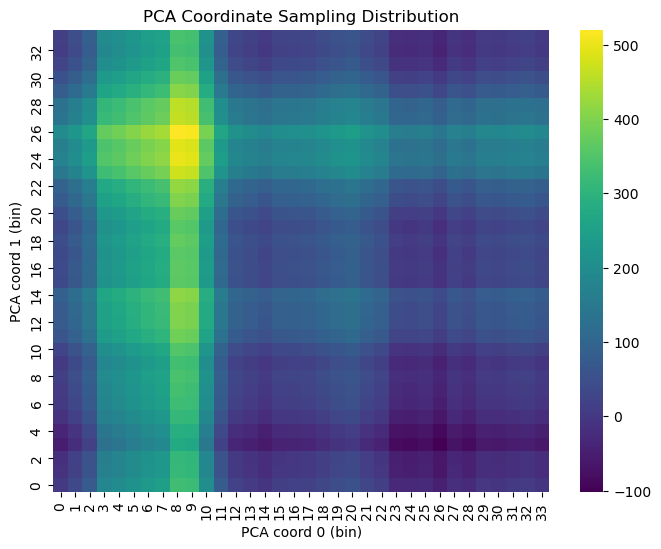

In [9]:
def check_joint_coordinate_fit(sequence_PCA, J_PCA, beta_PCA=1, nb_PCA_comp=2):
    sequence = sequence_PCA[:-nb_PCA_comp]  # Exclude PCA coordinates
    L = sequence.shape[0]
    Nbins = J_PCA.shape[1]
    best_energy = float('inf')
    best_coords = (None, None)

    for i in range(Nbins):  # PCA 0
        for j in range(Nbins):  # PCA 1
            energy = 0.0
            for pos in range(L):
                aa = sequence[pos]
                energy += beta_PCA * (J_PCA[aa, i, pos, 0] + J_PCA[aa, j, pos, 1])
            if energy < best_energy:
                best_energy = energy
                best_coords = (i, j)
    PCA_coords_true = sequence_PCA[-nb_PCA_comp:]
    print("True PCA coords:", PCA_coords_true)
    print("Best coords     :", best_coords)
    print("Min energy      :", best_energy)

init_sequence_num = seq_data_test_filtered_with_PCA[10000]
print(init_sequence_num[-2:])
print("initial sequence number:", init_sequence_num)
ratio = 0.
init_sequence_num = modify_seq(init_sequence_num, ratio,nb_PCA_comp=2)
print(init_sequence_num[-nb_PCA_comp:])
check_joint_coordinate_fit(init_sequence_num, Jtens_PCA, beta_PCA=1, nb_PCA_comp=2)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_probabilities_2D(probs, title="Probabilities Heatmap"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(probs, cmap='viridis', cbar=True)
    plt.gca().invert_yaxis()  # Invert y-axis to match PCA coordinate orientation
    plt.title(title)
    plt.xlabel("PCA coord 0 (bin)")
    plt.ylabel("PCA coord 1 (bin)")
    plt.show()

def compute_pca_probs_2D(sequence, J_PCA, beta_PCA=1.0):
    Nbins = J_PCA.shape[1]
    L = sequence.shape[0]
    probs = np.zeros((Nbins, Nbins))  # [PCA_comp_0, PCA_comp_1]

    for i in range(Nbins):  # trial coord for PCA comp 0
        for j in range(Nbins):  # trial coord for PCA comp 1
            energy = 0.0
            for pos in range(L):
                aa = sequence[pos]
                energy += beta_PCA * (J_PCA[aa, i, pos, 0] + J_PCA[aa, j, pos, 1])
            probs[i, j] = (energy)  # Boltzmann probability
    #probs /= probs.sum()  # Normalize
    return probs

# Example usage
sequence = init_sequence_num[:L]  # Only AA part, no PCA coords
probs_2D = compute_pca_probs_2D(sequence, Jtens_PCA, beta_PCA=1.0)
plot_probabilities_2D(probs_2D, title="PCA Coordinate Sampling Distribution")